In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


### Read data

In [13]:
df_train_sales = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv", parse_dates=['date'])
df_item_cat = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
df_items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
df_shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
df_test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

df_submission = pd.read_csv("../input/competitive-data-science-predict-future-sales/sample_submission.csv")

In [14]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [15]:
df_train_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [16]:
df_train_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [17]:
df_train_sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [18]:
df_shops.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

In [19]:
df_items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [20]:
import pandas_profiling as pp
pp.ProfileReport(df_train_sales)

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='item_price'>

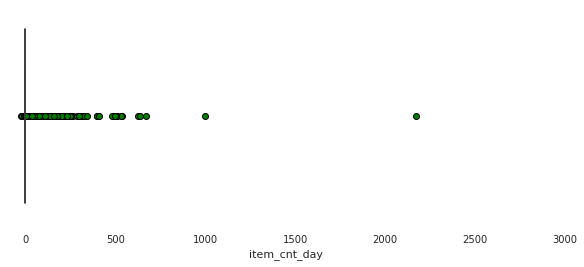

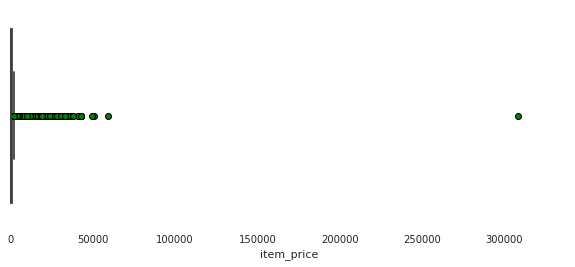

In [21]:
plt.figure(figsize=(10, 4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=df_train_sales.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(df_train_sales.item_price.min(), df_train_sales.item_price.max()*1.1)
sns.boxplot(x=df_train_sales.item_price, flierprops=flierprops)

In [22]:
df_train_sales = (
    df_train_sales
    [
        (df_train_sales['item_price'] > 0) &
        (df_train_sales['item_price'] < 300000) &
        (df_train_sales['item_cnt_day'] < 1000)
    ]
    .reset_index(drop = True)
)

df_train_sales.loc[df_train_sales['item_cnt_day'] < 0, 'item_cnt_day'] = 0

In [23]:
# Creating extra features based on date
df_train_sales['year'] = df_train_sales['date'].dt.year
df_train_sales['month'] = df_train_sales['date'].dt.month

In [24]:
df_train_sales_temp = pd.merge(df_train_sales, df_items, on='item_id', how='left')
df_train_sales_temp2 = pd.merge(df_train_sales_temp, df_item_cat, on='item_category_id', how='left')
df_train_sales_temp3 = pd.merge(df_train_sales_temp2, df_shops, on='shop_id', how='left')

df_train_sales_temp3.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,item_name,item_category_id,item_category_name,shop_name
0,2013-02-01,0,59,22154,999.00,1.0,2013,2,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-03-01,0,25,2552,899.00,1.0,2013,3,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-05-01,0,25,2552,899.00,0.0,2013,5,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-06-01,0,25,2554,1709.05,1.0,2013,6,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


In [25]:
df_train_sales_eda = df_train_sales_temp3.loc[(df_train_sales_temp3['shop_id'].isin(df_test['shop_id'])) &
                                              (df_train_sales_temp3['item_id'].isin(df_test['item_id']))].copy()

del df_train_sales_temp, df_train_sales_temp2, df_train_sales_temp3

In [26]:
df_train_sales_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,1224437.0,19.354708,9.110721,0.0,12.0,21.0,27.0,33.0
shop_id,1224437.0,32.151199,16.465618,2.0,19.0,31.0,46.0,59.0
item_id,1224437.0,9614.855129,6299.866953,30.0,4181.0,7856.0,15229.0,22167.0
item_price,1224437.0,1030.667670,1827.384781,0.5,299.0,549.0,1199.0,59200.0
item_cnt_day,1224437.0,1.321120,2.512867,0.0,1.0,1.0,1.0,624.0
year,1224437.0,2014.143838,0.768603,2013.0,2014.0,2014.0,2015.0,2015.0
month,1224437.0,6.683969,3.468410,1.0,4.0,7.0,10.0,12.0
item_category_id,1224437.0,40.558776,18.606798,2.0,25.0,38.0,55.0,83.0


##### Checking diversity of categorical feature item_name and shop_name

No. of unique items sold: 4716
Item name that repeats more than 5 times: 87%


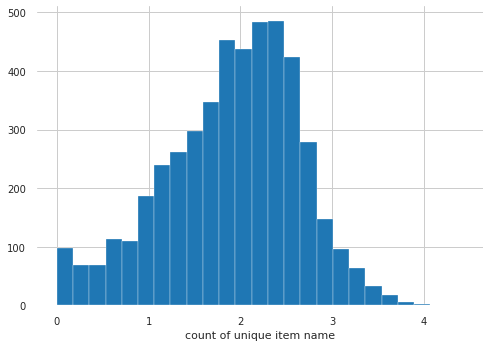

In [27]:
print("No. of unique items sold:", df_train_sales_eda['item_name'].nunique())

x = df_train_sales_eda['item_name'].value_counts()
np.log10(x).hist(bins=25)
plt.xlabel('count of unique item name');

print(f"Item name that repeats more than 5 times: {100*x[x>10].shape[0]/x.shape[0]:1.0f}%")

In [28]:
only_use_item_names = x[x>10].index

In [29]:
# Most sold item
x.nlargest(15)

Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм                                    26487
Playstation Store пополнение бумажника: Карта оплаты 1000 руб.                            7919
Прием денежных средств для 1С-Онлайн                                                      7896
Diablo III [PC, Jewel, русская версия]                                                    6337
Kaspersky Internet Security Multi-Device Russian Edition. 2-Device 1 year Renewal Box     5985
Call of Duty: Black Ops II [PС, Jewel, русская версия]                                    5408
World of Warcraft. Карта оплаты игрового времени (online) (рус.в.) (60 дней) (Jewel)      5393
Grand Theft Auto V [PS3, русские субтитры]                                                5375
Grand Theft Auto V [Xbox 360, русские субтитры]                                           4938
Minecraft [Xbox 360, английская версия]                                                   4932
PlayStation Plus 3-месячная подписка: Карта оплаты

No. of unique item category: 60
Item name that repeats more than 500 times: 100%


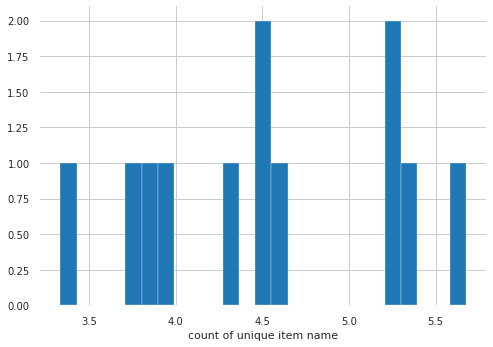

In [30]:
print("No. of unique item category:", df_train_sales_eda['item_category_name'].nunique())

df_train_sales_eda['item_category_name'] = df_train_sales_eda['item_category_name'].str.split().str[0]
x = df_train_sales_eda['item_category_name'].value_counts()
np.log10(x).hist(bins=25)
plt.xlabel('count of unique item name');

print(f"Item name that repeats more than 500 times: {100*x[x>5].shape[0]/x.shape[0]:1.0f}%")

In [31]:
only_use_item_cat_name = x[x>5].index

No. of unique shop names: 42
Shop name that repeats more than 300 time: 98%


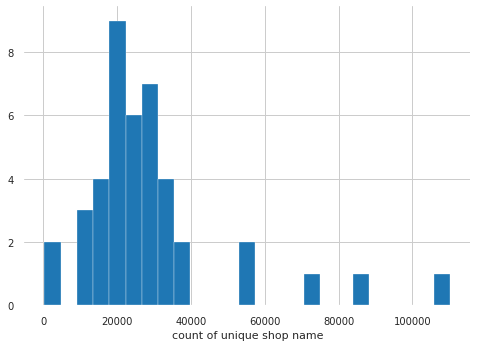

In [32]:
print("No. of unique shop names:", df_train_sales_eda['shop_name'].nunique())
x = df_train_sales_eda['shop_name'].value_counts()
x.hist(bins=25)
plt.xlabel('count of unique shop name');

print(f"Shop name that repeats more than 300 time: {100*x[x>500].shape[0]/x.shape[0]:1.0f}%")

In [33]:
only_use_shop_names = x[x>300].index

In [34]:
# Most item selling shop
x.nlargest(5)

Москва ТЦ "Семеновский"            110252
Москва ТРК "Атриум"                 85830
Москва ТЦ "МЕГА Теплый Стан" II     70861
СПб ТК "Невский Центр"              56214
Якутск Орджоникидзе, 56             53093
Name: shop_name, dtype: int64

<AxesSubplot:xlabel='year', ylabel='item_price'>

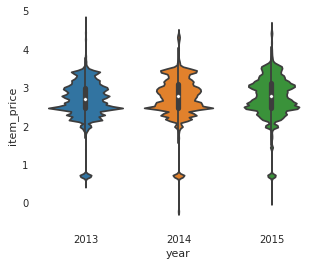

In [35]:
fig, ax = plt.subplots(figsize=(5,4))
sns.violinplot(x = df_train_sales_eda["year"]
               , y = np.log10(df_train_sales_eda['item_price']+0.1)
               , showfliers=False)

<AxesSubplot:xlabel='year', ylabel='item_price'>

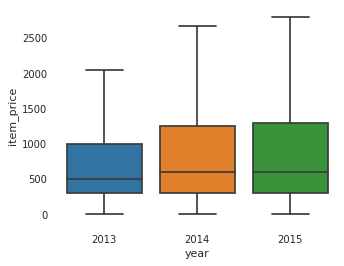

In [36]:
fig, ax = plt.subplots(figsize=(5,4))
sns.boxplot(x = df_train_sales_eda["year"]
               , y = df_train_sales_eda['item_price']
               , showfliers=False)

In [37]:
for year in [2013, 2014, 2015]:
    x = df_train_sales_eda.loc[df_train_sales_eda['year']==year, 'item_name'].value_counts().nlargest(5)
    print(f"Year: {year}\n", x, '\n')

Year: 2013
 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм                                   7181
Diablo III [PC, Jewel, русская версия]                                                  3272
StarCraft II: Wings of Liberty [PC, Jewel, русская версия]                              2514
World of Warcraft. Карта оплаты игрового времени (online) (рус.в.) (60 дней) (Jewel)    2496
Crysis 3 [PC, русская версия]                                                           2441
Name: item_name, dtype: int64 

Year: 2014
 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм                                    11425
Playstation Store пополнение бумажника: Карта оплаты 1000 руб.                            3390
Прием денежных средств для 1С-Онлайн                                                      3217
Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1108A/B01)                                   3024
Kaspersky Internet Security Multi-Device Russian Edition. 2-Device 1 year Renewal Box     2881
Name

In [38]:
for year in [2013, 2014, 2015]:
    x = df_train_sales_eda.loc[df_train_sales_eda['year']==year, 'shop_name'].value_counts().nlargest(5)
    print(f"Year: {year}\n", x, '\n')

Year: 2013
 Москва ТЦ "Семеновский"            26448
Москва ТРК "Атриум"                19701
Москва ТЦ "МЕГА Теплый Стан" II    16601
Якутск Орджоникидзе, 56            12228
СПб ТК "Невский Центр"             11518
Name: shop_name, dtype: int64 

Year: 2014
 Москва ТЦ "Семеновский"            42225
Москва ТРК "Атриум"                31599
Москва ТЦ "МЕГА Теплый Стан" II    27556
Якутск Орджоникидзе, 56            21390
СПб ТК "Невский Центр"             20264
Name: shop_name, dtype: int64 

Year: 2015
 Москва ТЦ "Семеновский"            41579
Москва ТРК "Атриум"                34530
Москва ТЦ "МЕГА Теплый Стан" II    26704
СПб ТК "Невский Центр"             24432
Якутск Орджоникидзе, 56            19475
Name: shop_name, dtype: int64 



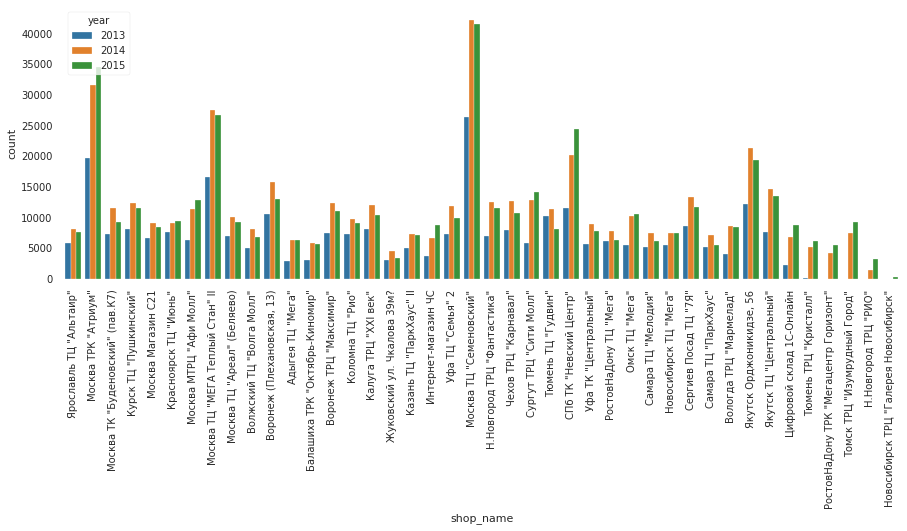

In [39]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x='shop_name', hue='year'
              ,data = df_train_sales_eda, ax=ax)
plt.xticks(rotation=90);

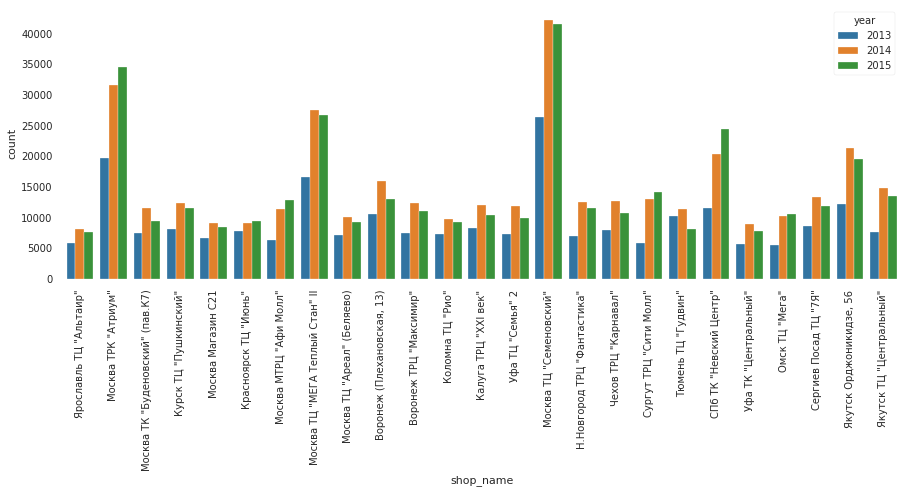

In [40]:
# 每年賣最多商品的店家

fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x='shop_name', hue='year'
              ,data = df_train_sales_eda.loc[df_train_sales_eda['shop_name'].\
                                             isin(df_train_sales_eda['shop_name'].\
                                                  value_counts().nlargest(25).index)], ax=ax)
plt.xticks(rotation=90);

All shop seems to have increasing sales trend with increasing years.

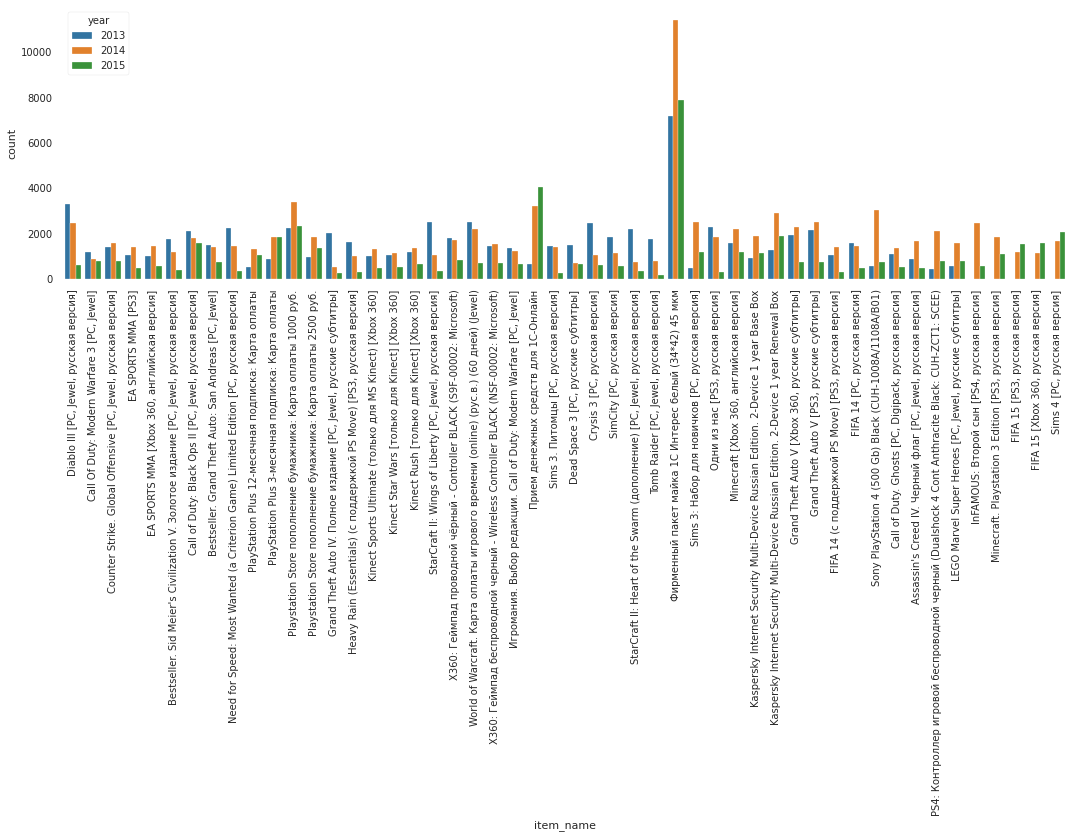

In [41]:
# 每年賣最多的商品

fig, ax = plt.subplots(figsize=(18,5))
sns.countplot(x='item_name', hue='year'
              ,data = df_train_sales_eda.loc[df_train_sales_eda['item_name'].\
                                             isin(df_train_sales_eda['item_name'].\
                                                  value_counts().nlargest(50).index)], ax=ax)
plt.xticks(rotation=90);

### Item count

In [42]:
df_train_sales_eda.\
    groupby(['shop_name', 'item_name']).\
    agg({'item_cnt_day': 'sum'}).\
    sort_values('item_cnt_day', ascending=False)

,,item_cnt_day
shop_name,item_name,
"Москва ТЦ ""Семеновский""",Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм,19934.0
"Москва ТРК ""Атриум""",Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм,14343.0
"Москва ТЦ ""МЕГА Теплый Стан"" II",Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм,13458.0
"СПб ТК ""Невский Центр""",Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм,10514.0
Интернет-магазин ЧС,Доставка (по Москве),6163.0
...,...,...
"Красноярск ТЦ ""Июнь""",MARLEY BOB & THE WAILERS Mellow Moods 2CD,1.0
"Сургут ТРЦ ""Сити Молл""","Lucius [PC, русская версия]",1.0
"Красноярск ТЦ ""Июнь""","MINECRAFT PAPERCRAFT - Игровой мир ""Вагонетка и ТНТ"" 48 деталей",1.0


In [43]:
# Shop name
df_train_sales_eda['shop_name'].unique()

array(['Ярославль ТЦ "Альтаир"', 'Москва ТРК "Атриум"',
       'Москва ТК "Буденовский" (пав.К7)', 'Курск ТЦ "Пушкинский"',
       'Москва Магазин С21', 'Красноярск ТЦ "Июнь"',
       'Москва МТРЦ "Афи Молл"', 'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Ареал" (Беляево)', 'Волжский ТЦ "Волга Молл"',
       'Воронеж (Плехановская, 13)', 'Адыгея ТЦ "Мега"',
       'Балашиха ТРК "Октябрь-Киномир"', 'Воронеж ТРЦ "Максимир"',
       'Коломна ТЦ "Рио"', 'Калуга ТРЦ "XXI век"',
       'Жуковский ул. Чкалова 39м?', 'Казань ТЦ "ПаркХаус" II',
       'Интернет-магазин ЧС', 'Уфа ТЦ "Семья" 2',
       'Москва ТЦ "Семеновский"', 'Н.Новгород ТРЦ "Фантастика"',
       'Чехов ТРЦ "Карнавал"', 'Сургут ТРЦ "Сити Молл"',
       'Тюмень ТЦ "Гудвин"', 'СПб ТК "Невский Центр"',
       'Уфа ТК "Центральный"', 'РостовНаДону ТЦ "Мега"', 'Омск ТЦ "Мега"',
       'Самара ТЦ "Мелодия"', 'Новосибирск ТЦ "Мега"',
       'Сергиев Посад ТЦ "7Я"', 'Самара ТЦ "ПаркХаус"',
       'Вологда ТРЦ "Мармелад"', 'Яку

In [44]:
df_train_sales_eda.loc[~df_train_sales_eda['shop_name'].isin(only_use_shop_names), 'shop_name'] = 'Unknown'
df_train_sales_eda.loc[~df_train_sales_eda['item_name'].isin(only_use_item_names), 'item_name'] = 'Unknown'
df_train_sales_eda.loc[~df_train_sales_eda['item_category_name'].isin(only_use_item_cat_name), 'item_category_name'] = 'Unknown'

In [45]:
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [46]:
# Label encoding
label_encoder = LabelEncoder()
df_train_sales_eda['shop_name'] = label_encoder.fit_transform(df_train_sales_eda['shop_name'])

label_encoder = LabelEncoder()
df_train_sales_eda['item_category_name'] = label_encoder.fit_transform(df_train_sales_eda['item_category_name'])

In [47]:
# 每date_block_num設shop_id跟item_id的組合

meta_features = ['date_block_num', 'shop_id', 'item_id']

train_agg_set = df_train_sales_eda.groupby(meta_features, as_index=False).size()

train_agg_set = train_agg_set[meta_features].copy()

train_agg_set

,date_block_num,shop_id,item_id
0,0,2,33
1,0,2,482
2,0,2,491
3,0,2,839
4,0,2,1007
...,...,...,...
600153,33,59,22087
600154,33,59,22088
600155,33,59,22091
600156,33,59,22100


#### Generating group features

In [48]:
df_train_sales_eda.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'year', 'month', 'item_name', 'item_category_id',
       'item_category_name', 'shop_name'],
      dtype='object')

In [49]:
group1 = df_train_sales_eda.groupby(meta_features, as_index=False).agg({'item_price': 'mean'
                                                                       ,'item_cnt_day': 'sum'})

train_agg_set = pd.merge(train_agg_set, group1, on=meta_features, how='left')

train_agg_set = train_agg_set.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})

In [50]:
train_agg_set.describe()

,date_block_num,shop_id,item_id,item_price_mean,item_cnt_month
count,600158.000000,600158.000000,600158.000000,600158.000000,600158.000000
mean,20.158757,32.061690,10014.863349,911.493269,2.695337
std,9.139361,16.889783,6192.898704,1565.816633,10.834638
min,0.000000,2.000000,30.000000,0.500000,0.000000
25%,13.000000,19.000000,4395.000000,299.000000,1.000000
50%,22.000000,31.000000,9089.000000,477.000000,1.000000
75%,28.000000,47.000000,15374.000000,1099.000000,2.000000
max,33.000000,59.000000,22167.000000,42990.000000,1305.000000


#### Train/Test

In [51]:
train_agg_set

,date_block_num,shop_id,item_id,item_price_mean,item_cnt_month
0,0,2,33,499.0,1.0
1,0,2,482,3300.0,1.0
2,0,2,491,600.0,1.0
3,0,2,839,3300.0,1.0
4,0,2,1007,449.0,3.0
...,...,...,...,...,...
600153,33,59,22087,119.0,6.0
600154,33,59,22088,119.0,2.0
600155,33,59,22091,179.0,1.0
600156,33,59,22100,629.0,1.0


In [53]:
df_test['date_block_num'] = 34

df_combo = pd.concat([train_agg_set, df_test.drop('ID', axis=1)], ignore_index=True, keys=meta_features)
df_combo = df_combo.fillna(0)

In [54]:
# Train data (Features)
X_train = df_combo[df_combo['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_month'], axis=1)

# Valid data (Features)
X_valid = df_combo[df_combo['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_month'], axis=1)

# Test data (Features)
X_test = df_combo[df_combo['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_month'], axis=1)

# Train data (Target values)
y_train = df_combo[df_combo['date_block_num'] < 33]['item_cnt_month']
# Valid data (Target values)
y_valid = df_combo[df_combo['date_block_num'] == 33]['item_cnt_month']

In [55]:
# lgb參數
params = {'metric': 'rmse',
          'num_leaves': 200,
          'learning_rate': 0.003, 'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5, 'force_col_wise' : True,
          'random_state': 42}



dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 

lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=2500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=250,
                      verbose_eval=250)      

[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 571478, number of used features: 4
[LightGBM] [Info] Start training from score 2.724219
Training until validation scores don't improve for 250 rounds
[250]	training's rmse: 8.16074	valid_1's rmse: 5.62855
[500]	training's rmse: 6.80697	valid_1's rmse: 4.97116
[750]	training's rmse: 6.14377	valid_1's rmse: 4.70647
[1000]	training's rmse: 5.75214	valid_1's rmse: 4.53731
[1250]	training's rmse: 5.52367	valid_1's rmse: 4.47314
[1500]	training's rmse: 5.36786	valid_1's rmse: 4.42739
[1750]	training's rmse: 5.25997	valid_1's rmse: 4.40593
[2000]	training's rmse: 5.17511	valid_1's rmse: 4.38562
[2250]	training's rmse: 5.10662	valid_1's rmse: 4.3712
[2500]	training's rmse: 5.04468	valid_1's rmse: 4.36318
Did not meet early stopping. Best iteration is:
[2500]	training's rmse: 5.04468	valid_1's rmse: 4.36318


In [56]:
preds = lgb_model.predict(X_test).clip(0,20)

df_submission['item_cnt_month'] = preds
df_submission.to_csv('submission.csv', index=False)
df_submission

,ID,item_cnt_month
0,0,2.323053
1,1,2.022543
2,2,1.961716
3,3,1.961716
4,4,2.022543
...,...,...
214195,214195,0.000000
214196,214196,0.000000
214197,214197,0.000000
214198,214198,0.000000
